In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Chargement du fichier Bronze
df = pd.read_parquet('../data/bronze_taxi.parquet')
print(f"Nombre de lignes initiales : {len(df)}")

Nombre de lignes initiales : 3475226


In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


In [4]:
# Statistiques descriptives
stats = df[['trip_distance', 'total_amount', 'passenger_count']].describe()
print(stats)

       trip_distance  total_amount  passenger_count
count   3.475226e+06  3.475226e+06     2.935077e+06
mean    5.855126e+00  2.561129e+01     1.297859e+00
std     5.646016e+02  4.636585e+02     7.507503e-01
min     0.000000e+00 -9.010000e+02     0.000000e+00
25%     9.800000e-01  1.520000e+01     1.000000e+00
50%     1.670000e+00  1.995000e+01     1.000000e+00
75%     3.100000e+00  2.778000e+01     1.000000e+00
max     2.764236e+05  8.633804e+05     9.000000e+00


In [5]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())


Valeurs manquantes par colonne :
VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          540149
trip_distance                 0
RatecodeID               540149
store_and_fwd_flag       540149
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     540149
Airport_fee              540149
cbd_congestion_fee            0
dtype: int64


In [6]:
# 2. Conversion des dates et calcul de la durée (Brief: Durée > 0)
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Calcul de la durée en minutes
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

In [7]:
# 3. Fonction de nettoyage conforme au Brief
def clean_taxi_data_brief(df_raw):
    df_clean = df_raw.copy()
    
    # - Distance > 0 et <= 200 miles
    # - Durée > 0 minutes
    # - Passagers > 0
    mask = (
        (df_clean['trip_distance'] > 0) & (df_clean['trip_distance'] <= 200) &
        (df_clean['duration'] > 0) &
        (df_clean['passenger_count'] > 0)
    )
    
    df_clean = df_clean[mask]
    
    # Suppression des doublons
    df_clean = df_clean.drop_duplicates()
    
    return df_clean

df_silver = clean_taxi_data_brief(df)

In [8]:
# 4. Feature Engineering (Brief: Heure, Jour de la semaine, Mois)
df_silver['pickup_hour'] = df_silver['tpep_pickup_datetime'].dt.hour
df_silver['day_of_week'] = df_silver['tpep_pickup_datetime'].dt.dayofweek
df_silver['month'] = df_silver['tpep_pickup_datetime'].dt.month

print(f"Nombre de lignes après nettoyage Silver : {len(df_silver)}")
print(f"Colonnes ajoutées : duration, pickup_hour, day_of_week, month")

Nombre de lignes après nettoyage Silver : 2871275
Colonnes ajoutées : duration, pickup_hour, day_of_week, month


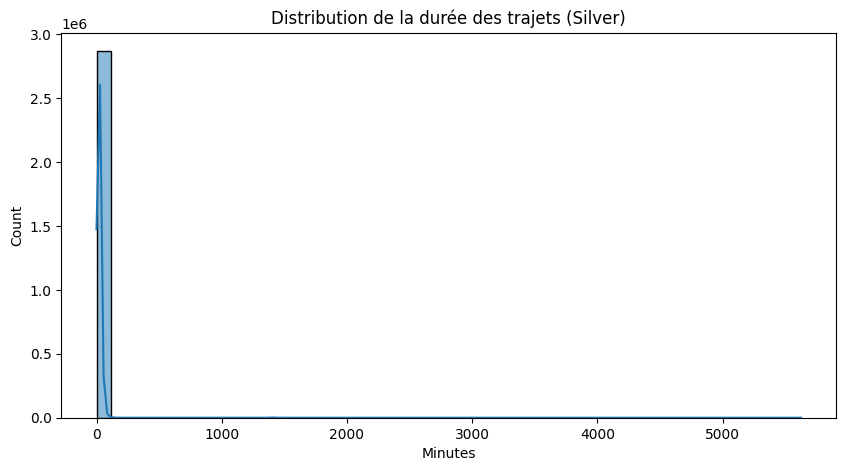

In [9]:
# 5. Visualisation de contrôle (Optionnel mais recommandé)
plt.figure(figsize=(10, 5))
sns.histplot(df_silver['duration'], bins=50, kde=True)
plt.title("Distribution de la durée des trajets (Silver)")
plt.xlabel("Minutes")
plt.show()

In [10]:
# 6. Sauvegarde du fichier Silver
df_silver.to_parquet('../data/silver_taxi.parquet', index=False)
print("Fichier Silver sauvegardé avec succès.")

Fichier Silver sauvegardé avec succès.


Conclusion:<br><br>
-On remarque que le nombre de lignes a diminué. C'est le but de la Zone Silver : on sacrifie la quantité pour la qualité. Un modèle entraîné sur 3 millions de lignes propres sera toujours plus performant qu'un modèle sur 10 millions de lignes contenant des erreurs.<br><br>
-En isolant l'heure et le jour, On permets à l'IA de comprendre que "Lundi à 8h" n'est pas la même chose que "Dimanche à 8h". C'est la base de la prédiction de l'ETA.<br><br>
-duration : C'est la valeur que nous allons chercher à prédire. En la calculant dès maintenant, On prépares le terrain pour l'étape de Machine Learning.